
### Random Acts of Pizza
### Sybil Santos-Burgan, Shane Kramer, Monali, Jose Torres
### 207 Final Project Scratchpad
### 03.28.22 - Ensemble A

In [186]:
import re
import numpy as np 
import pandas as pd 
import json
import nltk 
from pandas import json_normalize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import *
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [79]:
# Read JSON file
df = pd.read_json('/content/drive/MyDrive/W207/FinalProject/w207_final_project/src/data/train.json')

# For the entire training set, add column for request text count, create label obejct, 
# And purge the request_texct_count column from training data
full_df = df.copy()
full_df['request_text_count'] = df['request_text'].str.count(' ') + 1
full_labels = full_df['requester_received_pizza']
full_df = full_df.drop('requester_received_pizza', axis=1)

dev_size=1000

# Build train and dev data sets
LR_train_data, LR_train_labels = full_df[dev_size:], full_labels[dev_size:]
LR_dev_data, LR_dev_labels = full_df[:dev_size], full_labels[:dev_size]

NB_train_data, NB_train_labels = full_df.request_text[dev_size:], full_labels[dev_size:]
NB_dev_data, NB_dev_labels = full_df.request_text[:dev_size], full_labels[:dev_size]

SVM_train_data, SVM_train_labels = full_df[dev_size:], full_labels[dev_size:]
SVM_dev_data, SVM_dev_labels = full_df[:dev_size], full_labels[:dev_size]



In [50]:
##### Confusion Matrix Function #####
def plotConfusionMatrix(cnf_matrix):
  # Plot results
  class_names=[0,1] # name  of classes
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)

  # create heatmap
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


###################################################################
Tuned Linear Regression Metrics & Confusion Matrix Against Dev Data
###################################################################
AUC:  0.7603430353430354
Accuracy: 0.793
              precision    recall  f1-score   support

       False       0.88      0.83      0.86       740
        True       0.59      0.69      0.63       260

    accuracy                           0.79      1000
   macro avg       0.74      0.76      0.75      1000
weighted avg       0.81      0.79      0.80      1000



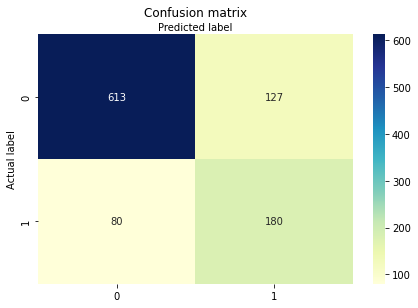

In [173]:
###################################################################
# Linear Regression
###################################################################
# Now need to split into features and targets
feature_cols = ['request_text_count', 
                'number_of_upvotes_of_request_at_retrieval',
                'request_number_of_comments_at_retrieval',
                'requester_account_age_in_days_at_retrieval',
                'requester_days_since_first_post_on_raop_at_retrieval',
                'requester_number_of_comments_at_retrieval',
                'requester_number_of_comments_in_raop_at_request',
                'requester_number_of_comments_in_raop_at_retrieval',
                'requester_number_of_posts_on_raop_at_request',
                'requester_number_of_posts_on_raop_at_retrieval', 
                ]

X = LR_train_data[feature_cols]
Y = LR_train_labels

# Create and train model using train data
# Had to set max_iter to a really high number for LR to work with so many dimensions
logreg = LogisticRegression(class_weight='balanced', max_iter=10000)
logreg.fit(X, Y)

# Run model against real dev data
X_dev = LR_dev_data[feature_cols]
Y_dev_LRPred = logreg.predict(X_dev)

# Score linear model against dev data
print("")
print("###################################################################")
print("Tuned Linear Regression Metrics & Confusion Matrix Against Dev Data")
print("###################################################################")
cnf_matrix = metrics.confusion_matrix(LR_dev_labels, Y_dev_LRPred)
plotConfusionMatrix(cnf_matrix)

fpr, tpr, thresholds = metrics.roc_curve(LR_dev_labels, Y_dev_LRPred, pos_label=1)
print("AUC: ", metrics.auc(fpr, tpr))

print("Accuracy:",metrics.accuracy_score(LR_dev_labels, Y_dev_LRPred))
print(classification_report(LR_dev_labels, Y_dev_LRPred))

In [52]:
###################################################################
# Pre-Processor for NB
###################################################################
nltk.download('stopwords')
    
cachedStopWords = stopwords.words("english")
ps = PorterStemmer()

def myPreprocessor(data):
   filteredData = re.sub('[^A-Za-z0-9 \n]+', ' ', data.lower())
   filteredData = ' '.join([word for word in filteredData.split() 
      if word not in cachedStopWords])
   filteredData = ' '.join([word[0:6] if len(word) > 6 else 
                            word for word in filteredData.split()])
   return filteredData

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



###################################################################
Tuned Naive Bayes Metrics & Confusion Matrix Against Dev Data
###################################################################
AUC:  0.512993762993763
Accuracy: 0.63
              precision    recall  f1-score   support

       False       0.75      0.76      0.75       740
        True       0.28      0.27      0.27       260

    accuracy                           0.63      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.63      0.63      0.63      1000



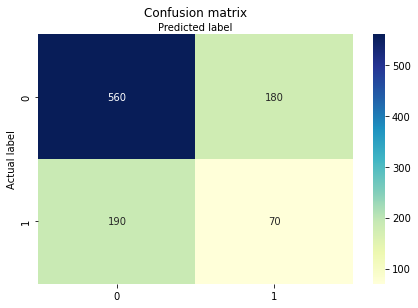

In [85]:
###################################################################
# Naive Bayes - Complement NB + Alpha = .07
###################################################################
ppVectorizer = CountVectorizer(preprocessor=myPreprocessor)
ppTrainVector = ppVectorizer.fit_transform(NB_train_data)
ppDevVector = ppVectorizer.transform(NB_dev_data)

mnb = ComplementNB(alpha = .07)
mnb.fit(ppTrainVector, NB_train_labels)

Y_dev_NBPred = mnb.predict(ppDevVector)

# Score Naive Bayes against dev data
print("")
print("###################################################################")
print("Tuned Naive Bayes Metrics & Confusion Matrix Against Dev Data")
print("###################################################################")
cnf_matrix = metrics.confusion_matrix(NB_dev_labels, Y_dev_NBPred)
plotConfusionMatrix(cnf_matrix)

fpr, tpr, thresholds = metrics.roc_curve(NB_dev_labels, Y_dev_NBPred, pos_label=1)
print("AUC: ", metrics.auc(fpr, tpr))

print("Accuracy:",metrics.accuracy_score(NB_dev_labels, Y_dev_NBPred))
print(classification_report(NB_dev_labels, Y_dev_NBPred))


###################################################################
Tuned SVM Metrics & Confusion Matrix Against Dev Data
###################################################################
AUC:  0.7126299376299376
Accuracy: 0.811
              precision    recall  f1-score   support

       False       0.84      0.92      0.88       740
        True       0.68      0.51      0.58       260

    accuracy                           0.81      1000
   macro avg       0.76      0.71      0.73      1000
weighted avg       0.80      0.81      0.80      1000



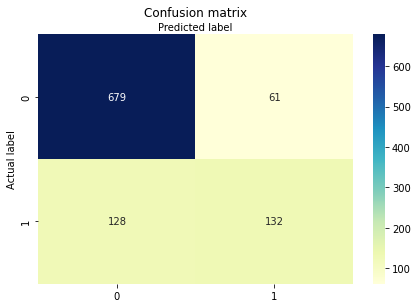

In [158]:
###################################################################
# SVM - Linear - Text count + number of comments
###################################################################
feature_cols = ['request_text_count', 
                'requester_number_of_posts_on_raop_at_retrieval',
                'requester_number_of_comments_at_retrieval'
               ]

X = SVM_train_data[feature_cols]
Y = SVM_train_labels
X_dev = SVM_dev_data[feature_cols]

clf = svm.SVC(kernel='linear', probability=True) # Linear Kernel
clf.fit(X, Y)
Y_dev_SVMPred = clf.predict(X_dev)

# Score LVM against dev data
print("")
print("###################################################################")
print("Tuned SVM Metrics & Confusion Matrix Against Dev Data")
print("###################################################################")
cnf_matrix = metrics.confusion_matrix(SVM_dev_labels, Y_dev_SVMPred)
plotConfusionMatrix(cnf_matrix)

fpr, tpr, thresholds = metrics.roc_curve(SVM_dev_labels, Y_dev_SVMPred, pos_label=1)
print("AUC: ", metrics.auc(fpr, tpr))

print("Accuracy:",metrics.accuracy_score(SVM_dev_labels, Y_dev_SVMPred))
print(classification_report(SVM_dev_labels, Y_dev_SVMPred))


###################################################################
Ensemble Metrics & Confusion Matrix Against Dev Data
###################################################################
AUC:  0.7514033264033264
Accuracy: 0.837
              precision    recall  f1-score   support

       False       0.86      0.93      0.89       740
        True       0.74      0.57      0.65       260

    accuracy                           0.84      1000
   macro avg       0.80      0.75      0.77      1000
weighted avg       0.83      0.84      0.83      1000



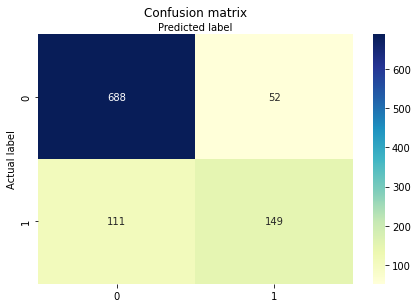

In [224]:
###################################################################
# Random Forest - Tuned - depth=20, random state = 0, classweights75/25
###################################################################
X = LR_train_data[feature_cols]
Y = LR_train_labels
X_test = LR_dev_data[feature_cols]

classWeights =  {0: .75,
                 1: .25}
                
rfc = RandomForestClassifier(max_depth = 20, random_state=0, class_weight=classWeights)

rfc.fit(X, Y)
Y_dev_RF_pred = rfc.predict(X_test)

# Score Ensemble against dev data
print("")
print("###################################################################")
print("Random Forest Metrics & Confusion Matrix Against Dev Data")
print("###################################################################")
cnf_matrix = metrics.confusion_matrix(NB_dev_labels, Y_dev_RF_pred)
plotConfusionMatrix(cnf_matrix)

fpr, tpr, thresholds = metrics.roc_curve(NB_dev_labels, Y_dev_RF_pred, pos_label=1)
print("AUC: ", metrics.auc(fpr, tpr))
print("Accuracy:",metrics.accuracy_score(SVM_dev_labels, Y_dev_RF_pred))
print(classification_report(SVM_dev_labels, Y_dev_RF_pred))


###################################################################
Home-made Ensemble Metrics & Confusion Matrix Against Dev Data
###################################################################
AUC:  0.7478170478170479
Accuracy: 0.828
              precision    recall  f1-score   support

       False       0.86      0.91      0.89       740
        True       0.71      0.58      0.64       260

    accuracy                           0.83      1000
   macro avg       0.78      0.75      0.76      1000
weighted avg       0.82      0.83      0.82      1000



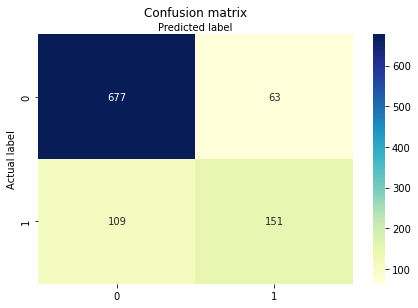

In [229]:
###################################################################
# HOME-MADE ENSEMBLE & TEST
###################################################################

Y_dev_EnsemblePred = (Y_dev_LRPred.astype(int) * 8) + \
                     (Y_dev_NBPred.astype(int) * 5) + \
                     (Y_dev_SVMPred.astype(int) * 8) + \
                     (Y_dev_RF_pred.astype(int) * 8)

for index, prediction in enumerate(Y_dev_EnsemblePred):
  if prediction >=15:
    Y_dev_EnsemblePred[index] = 1
  else:
    Y_dev_EnsemblePred[index] = 0

# Score Ensemble against dev data
print("")
print("###################################################################")
print("Home-made Ensemble Metrics & Confusion Matrix Against Dev Data")
print("###################################################################")
cnf_matrix = metrics.confusion_matrix(NB_dev_labels, Y_dev_EnsemblePred)
plotConfusionMatrix(cnf_matrix)

fpr, tpr, thresholds = metrics.roc_curve(NB_dev_labels, Y_dev_EnsemblePred, pos_label=1)
print("AUC: ", metrics.auc(fpr, tpr))

print("Accuracy:",metrics.accuracy_score(SVM_dev_labels, Y_dev_EnsemblePred))
print(classification_report(SVM_dev_labels, Y_dev_EnsemblePred))

In [167]:
###################################################################
# Scores function, pulled from 
#   https://machinelearningmastery.com/weighted-average-ensemble-with-python/
###################################################################

def evaluate_models(models, X_train, X_val, y_train, y_val):
	# fit and evaluate the models
	scores = list()
	for name, model in models:
		# fit the model
		model.fit(X_train, y_train)
		# evaluate the model
		yhat = model.predict(X_val)
		fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat, pos_label=1)
   	# store the performance
		scores.append(metrics.auc(fpr, tpr))
		# report model performance
	return scores


###################################################################
Ensemble Metrics & Confusion Matrix Against Dev Data
###################################################################
AUC:  0.7670997920997921
Accuracy: 0.827
              precision    recall  f1-score   support

       False       0.88      0.89      0.88       740
        True       0.68      0.64      0.66       260

    accuracy                           0.83      1000
   macro avg       0.78      0.77      0.77      1000
weighted avg       0.82      0.83      0.83      1000



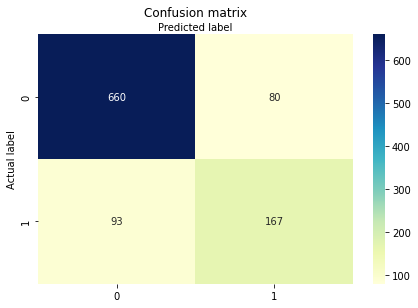

In [231]:


###################################################################
# Scikit ENSEMBLE (soft voting) & TEST
###################################################################
scores= [.8, .8]
models = list()
models.append(('lr', logreg))
models.append(('rfc', rfc))
#models.append(('svm', svm))

X = LR_train_data[feature_cols]
Y = LR_train_labels
X_test = LR_dev_data[feature_cols]
#scores = evaluate_models(models, X , Y, X_test, LR_dev_labels)

ensemble = VotingClassifier(estimators=models, voting='soft', weights=scores)
ensemble.fit(X, Y)
ensemble_pred = ensemble.predict(X_test)

# Score Ensemble against dev data
print("")
print("###################################################################")
print("Scikit Ensemble Metrics & Confusion Matrix Against Dev Data")
print("###################################################################")
cnf_matrix = metrics.confusion_matrix(NB_dev_labels, ensemble_pred)
plotConfusionMatrix(cnf_matrix)

fpr, tpr, thresholds = metrics.roc_curve(NB_dev_labels, ensemble_pred, pos_label=1)
print("AUC: ", metrics.auc(fpr, tpr))

print("Accuracy:",metrics.accuracy_score(SVM_dev_labels, ensemble_pred))
print(classification_report(SVM_dev_labels, ensemble_pred))